<a href="https://colab.research.google.com/github/nanlou888/Machine_Learing_MMA/blob/main/RSM8413_GroupAssignment1_Team12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Executive Summary**

***Problem Statement***

Predict if an auction on eBay would be competitive or non-competitive based on auctions that transacted on eBay.com during May-June 2004. Predicting whether an auction would be competitive or not will help eBay boost revenue and seller success by identifying non-competitive listings and provide recommendations to make them more attractive. This would improve seller retention, buyer engagement and overall positive market health.

***Approach***

***Key Findings***

***Recommendations***

***Team Contributions***

EDA - Zimeng, Data Preprocessing - Peter, Model 1 KNN (baseline + tuning) - Zoe & Yaojie, Model 2 DT (baseline + tuning) - Harrison, Comparisons & Recommendations


Please note - if multiple ppl are working on the notebook together - Zimeng & peter - since you'll be working on EDA + data cleaning today - pls coordinate/create copies of the notebook and add final code back here

Also when you are running the code - make sure you upload the dataset in the folder on the left-  it deletes it everytime the run time session turns off


## 🔹 How to sync Colab notebook with GitHub

### 1. Open from GitHub

* In Colab: **File → Open notebook → GitHub**
* Paste your repo URL (e.g. `https://github.com/username/repo`) and choose the `.ipynb` file to open.
* This gives you a copy that’s linked to GitHub.

### 2. Save (commit) back to GitHub

* After editing your notebook, go to **File → Save a copy in GitHub**.
* Choose:

  * Repository
  * Branch
  * Folder (optional)
* Add a **commit message** (e.g. “Update Decision Tree notebook”).
* Click **OK** → it’ll commit the file to your repo.

---

## 🔹 Tips

* You can’t have a *live sync* (every edit auto-pushes to GitHub). It’s **manual commits**.
* If you want version control inside Colab, use `git` commands in a code cell:

```python
# Authenticate
from google.colab import auth
auth.authenticate_user()

# Config Git
!git config --global user.email "your_email@example.com"
!git config --global user.name "your_username"

# Clone your repo
!git clone https://github.com/username/repo.git
%cd repo

# Save Colab notebook into repo, then commit & push
!git add "Decision Tree.ipynb"
!git commit -m "Update notebook from Colab"
!git push origin main
```

👉 For private repos, you’ll need a **GitHub Personal Access Token** in the clone URL:

```
https://<TOKEN>@github.com/username/repo.git
```

---

✅ So the simplest way for your notebook (`Decision Tree.ipynb`) is:

* Open it in Colab.
* Do **File → Save a copy in GitHub**.

---

In [ ]:
#Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
uploaded = files.upload()



Saving ebayAuctions.xlsx to ebayAuctions.xlsx


# **EDA**

***Approach***

***Key Findings***

In [ ]:
auctions_df = pd.read_excel("ebayAuctions.xlsx", sheet_name='eBay auctions')
auctions_df.head(10)


,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
5,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
6,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
7,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
8,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
9,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [ ]:
print(auctions_df.shape)
print(auctions_df.info())

(1972, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972 entries, 0 to 1971
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Category      1972 non-null   category
 1   Currency      1972 non-null   category
 2   sellerRating  1972 non-null   int64   
 3   Duration      1972 non-null   int64   
 4   endDay        1972 non-null   category
 5   ClosePrice    1972 non-null   float64 
 6   OpenPrice     1972 non-null   float64 
 7   Competitive?  1972 non-null   int64   
dtypes: category(3), float64(2), int64(3)
memory usage: 84.1 KB
None


In [ ]:
#convert object dtypes to category
auctions_df['Category'] = auctions_df['Category'].astype('category')
auctions_df['Currency'] = auctions_df['Currency'].astype('category')
auctions_df['endDay'] = auctions_df['endDay'].astype('category')
auctions_df.info()

In [ ]:
#summary analysis
print(auctions_df.describe())
print(auctions_df.describe(include=['category']))

       sellerRating     Duration   ClosePrice    OpenPrice  Competitive?
count   1972.000000  1972.000000  1972.000000  1972.000000   1972.000000
mean    3560.238337     6.486308    36.449087    12.926268      0.540568
std     5973.011033     2.052906    89.493858    38.856149      0.498478
min        0.000000     1.000000     0.010000     0.010000      0.000000
25%      595.000000     5.000000     4.907500     1.230000      0.000000
50%     1853.000000     7.000000     9.995000     4.500000      1.000000
75%     3380.000000     7.000000    28.000000     9.990000      1.000000
max    37727.000000    10.000000   999.000000   999.000000      1.000000
                Category Currency endDay
count               1972     1972   1972
unique                18        3      7
top     Music/Movie/Game       US    Mon
freq                 403     1292    548


**Univariate Analysis**

In [ ]:
#exploring the target
auctions_df["Competitive?"].value_counts()

,count
Competitive?,
1,1066
0,906


In [ ]:
auctions_df["Competitive?"].value_counts(normalize = True) * 100

,proportion
Competitive?,
1,54.056795
0,45.943205


,0
sellerRating,"Axes(0.125,0.712609;0.168478x0.167391)"
Duration,"Axes(0.327174,0.712609;0.168478x0.167391)"
ClosePrice,"Axes(0.529348,0.712609;0.168478x0.167391)"
OpenPrice,"Axes(0.731522,0.712609;0.168478x0.167391)"


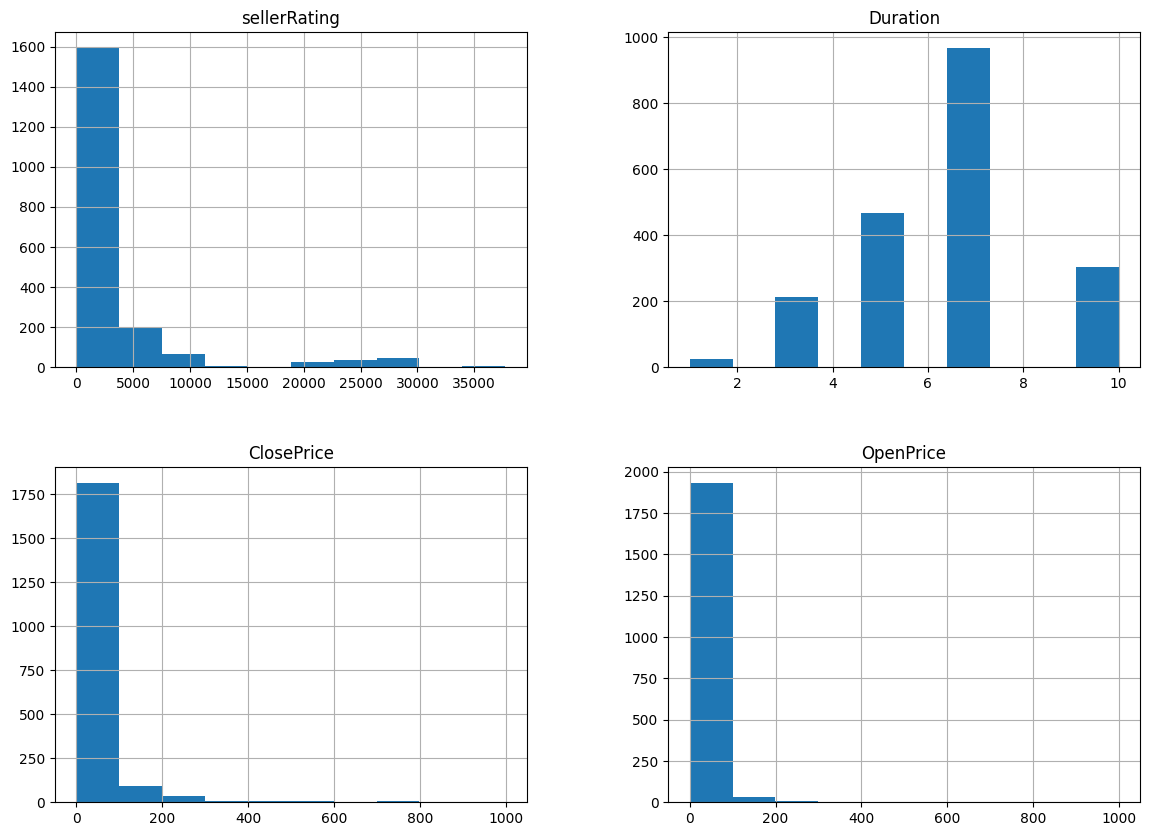

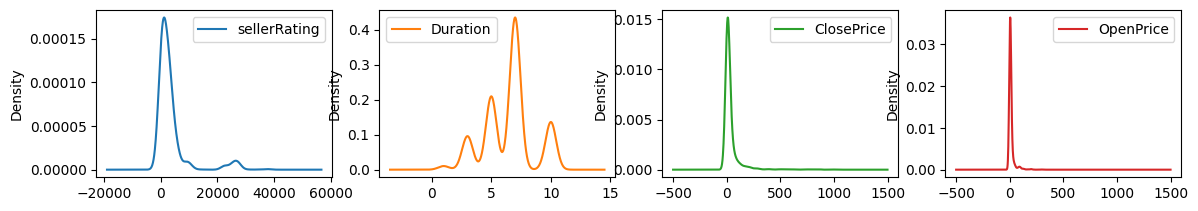

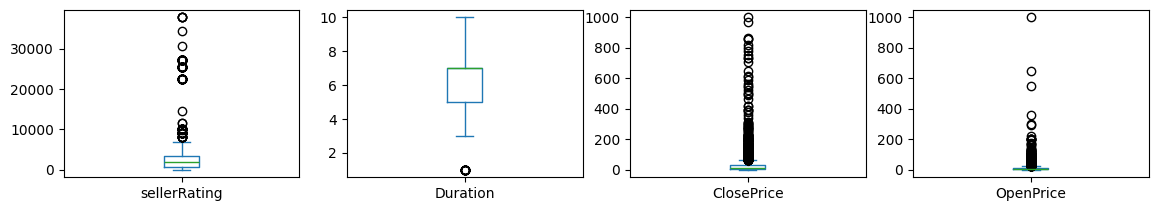

In [ ]:
# exploring numerical variables
num_vars = auctions_df.select_dtypes(include=['int64', 'float64']).columns.drop('Competitive?')
auctions_df[num_vars].hist(figsize=(14,10))
# Density Plots
auctions_df[num_vars].plot(figsize=(14,10), kind='density', subplots=True, layout=(4,4),
sharex=False)

# Box and Whisker Plots
auctions_df[num_vars].boxplot(figsize=(14,10))
plt.xticks(rotation=90)
auctions_df[num_vars].plot(figsize=(14,10), kind='box', subplots=True, layout=(4,4),
sharex=False, sharey=False)

In [ ]:
#explore categorical vars (univariate analysis)

**Bivariate Analysis**

<Axes: xlabel='Category'>

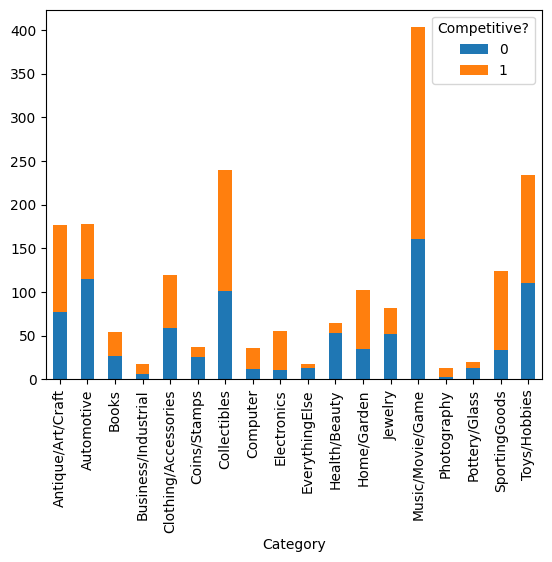

In [ ]:
auctions_df_crosstab = pd.crosstab(auctions_df["Competitive?"], auctions_df["Category"],margins=False)
pd.crosstab(auctions_df["Competitive?"], auctions_df["Category"], margins=True)
#sns.countplot(x="Category", hue="Competitive?", data=auctions_df)
auctions_df_crosstab = auctions_df_crosstab.transpose()
auctions_df_crosstab.plot(kind = 'bar', stacked = True)

<Axes: xlabel='Category'>

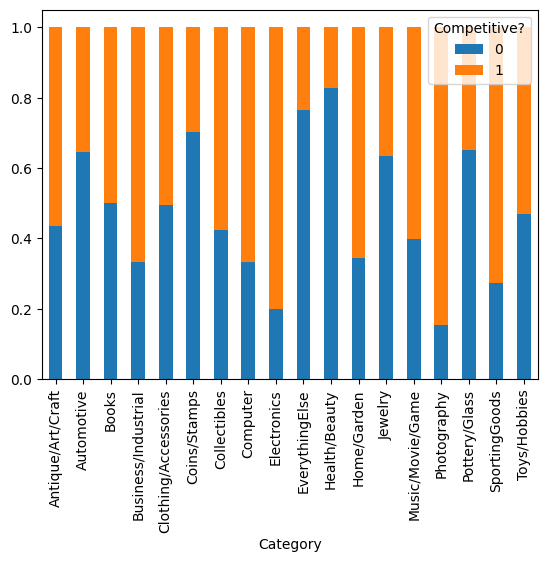

In [ ]:
auctions_df_crosstab = pd.crosstab(
    auctions_df["Competitive?"],
    auctions_df["Category"],
    margins=False
)
auctions_df_crosstab = auctions_df_crosstab.transpose()

auctions_df_crosstab = auctions_df_crosstab.div(auctions_df_crosstab.sum(axis=1), axis=0)

auctions_df_crosstab.plot(kind="bar", stacked=True)


<Axes: xlabel='Currency', ylabel='count'>

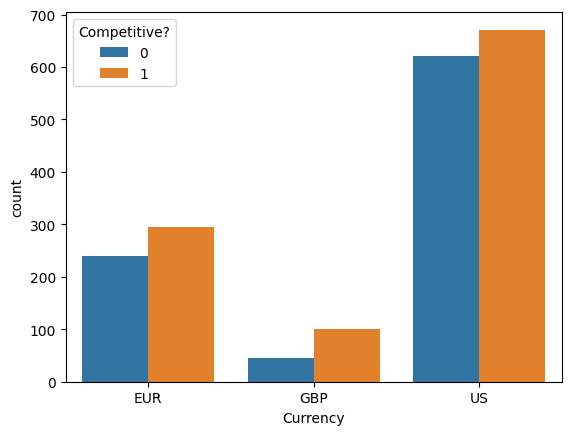

In [ ]:
auctions_df_crosstab = pd.crosstab(auctions_df["Competitive?"], auctions_df["Currency"],margins=False)
pd.crosstab(auctions_df["Competitive?"], auctions_df["Currency"], margins=True)
sns.countplot(x="Currency", hue="Competitive?", data=auctions_df)

<Axes: xlabel='Currency'>

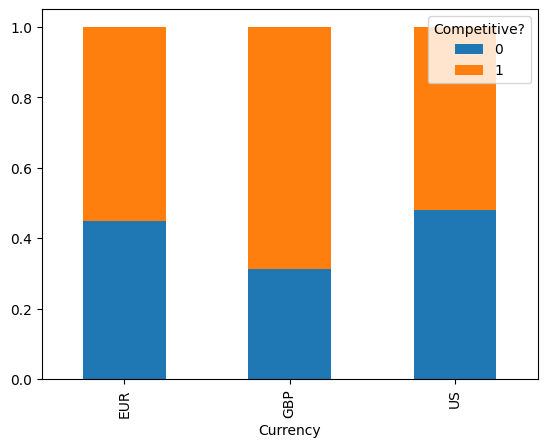

In [ ]:
auctions_df_crosstab = pd.crosstab(
    auctions_df["Competitive?"],
    auctions_df["Currency"],
    margins=False
)
auctions_df_crosstab = auctions_df_crosstab.transpose()

auctions_df_crosstab = auctions_df_crosstab.div(auctions_df_crosstab.sum(axis=1), axis=0)

auctions_df_crosstab.plot(kind="bar", stacked=True)


<Axes: xlabel='endDay', ylabel='count'>

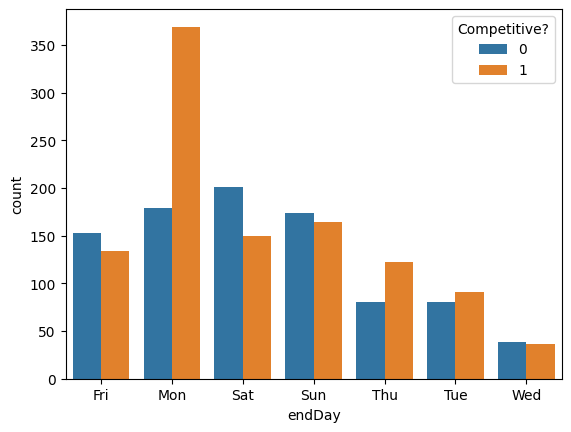

In [ ]:
auctions_df_crosstab = pd.crosstab(auctions_df["Competitive?"], auctions_df["endDay"],margins=False)
pd.crosstab(auctions_df["Competitive?"], auctions_df["endDay"], margins=True)
sns.countplot(x="endDay", hue="Competitive?", data=auctions_df)

<Axes: xlabel='endDay'>

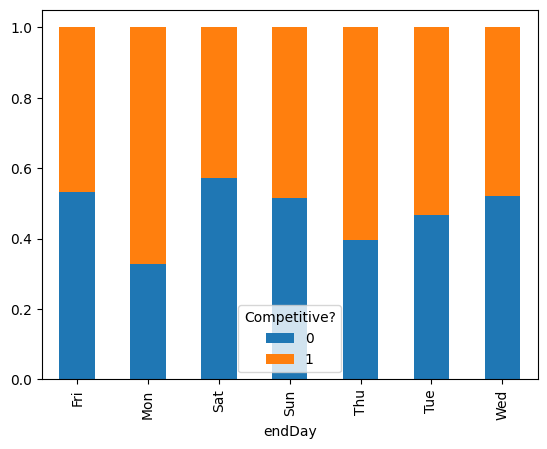

In [ ]:
auctions_df_crosstab = pd.crosstab(
    auctions_df["Competitive?"],
    auctions_df["endDay"],
    margins=False
)

auctions_df_crosstab = auctions_df_crosstab.transpose()

auctions_df_crosstab = auctions_df_crosstab.div(auctions_df_crosstab.sum(axis=1), axis=0)

auctions_df_crosstab.plot(kind="bar", stacked=True)


/tmp/ipython-input-3716998923.py:19: RuntimeWarning: invalid value encountered in divide
  n_norm = n_table / n_table.sum(axis=1)[:, None]


<BarContainer object of 10 artists>

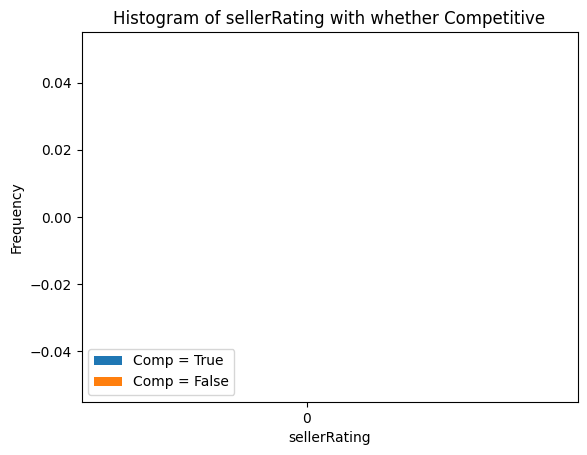

In [ ]:
# Separate variable Customer Service Calls by the two values of the target
Comp_rating_T = auctions_df[auctions_df["Competitive?"] == "True."] ["sellerRating"]
Comp_rating_F = auctions_df[auctions_df["Competitive?"] == "False."] ["sellerRating"]

# Create a stacked histogram of the two variables
plt.hist([Comp_rating_T, Comp_rating_F], bins = 10, stacked = True)
plt.legend(['Comp = True', 'Comp = False'])
plt.title('Histogram of sellerRating with whether Competitive')
plt.xlabel('sellerRating')
plt.ylabel('Frequency')
xlabels = np.arange(10) # the labels
xpos = [x*0.9+0.45 for x in xlabels] # the label locations
plt.xticks(xpos, xlabels)
# Normalized Values
(n, bins, patches) = plt.hist([Comp_rating_T, Comp_rating_F], bins = 10,
stacked = True)
n[1] = n[1] - n[0]
n_table = np.column_stack((n[0], n[1]))
n_norm = n_table / n_table.sum(axis=1)[:, None]
ourbins = np.column_stack((bins[0:10], bins[1:11]))
plt.bar(x = ourbins[:,0], height = n_norm[:,0], width = ourbins[:, 1] -
ourbins[:, 0])

**Multivariate Analysis**

# **Data Processing**

***Approach***

***Key Findings***

In [ ]:


def preprocess_ebay_auctions(file_path: str):
    df = pd.read_excel(file_path, sheet_name="eBay auctions")
    if "Currency" in df.columns and df["Currency"].nunique() == 1:
        df = df.drop(columns=["Currency"])
    label_enc = LabelEncoder()
    if "Category" in df.columns:
        df["Category"] = label_enc.fit_transform(df["Category"])
    if "endDay" in df.columns:
        df["endDay"] = label_enc.fit_transform(df["endDay"])
    scaler = StandardScaler()
    num_cols = ["sellerRating", "Duration", "OpenPrice", "ClosePrice"]
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

file_path = "ebayAuctions.xlsx"
df_preprocessed = preprocess_ebay_auctions(file_path)
print(df_preprocessed.head())


   Category Currency  sellerRating  Duration  endDay  ClosePrice  OpenPrice  \
0        13       US     -0.052121 -0.724186       1   -0.407272  -0.332497   
1        13       US     -0.052121 -0.724186       1   -0.407272  -0.332497   
2        13       US     -0.052121 -0.724186       1   -0.407272  -0.332497   
3        13       US     -0.052121 -0.724186       1   -0.407272  -0.332497   
4        13       US     -0.052121 -0.724186       1   -0.407272  -0.332497   

   Competitive?  
0             0  
1             0  
2             0  
3             0  
4             0  


# **Model Experimentation - KNN**

***Approach***

***Key Findings***

***Baseline Model***

In [ ]:
df_preprocessed

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,13,US,-0.052121,-0.724186,1,-0.407272,-0.332497,0
1,13,US,-0.052121,-0.724186,1,-0.407272,-0.332497,0
2,13,US,-0.052121,-0.724186,1,-0.407272,-0.332497,0
3,13,US,-0.052121,-0.724186,1,-0.407272,-0.332497,0
4,13,US,-0.052121,-0.724186,1,-0.407272,-0.332497,0
...,...,...,...,...,...,...,...,...
1967,1,US,-0.095158,-0.724186,3,3.615700,8.933252,0
1968,1,US,-0.592689,-0.724186,2,6.410455,7.389990,1
1969,1,US,-0.361758,-0.724186,1,5.728672,13.799867,0
1970,1,US,-0.586660,0.250290,0,8.757580,16.399858,1


In [ ]:
X= df_preprocessed.iloc[:,:-1]
X

,Category,Currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice
0,13,US,-0.052121,-0.724186,1,-0.407272,-0.332497
1,13,US,-0.052121,-0.724186,1,-0.407272,-0.332497
2,13,US,-0.052121,-0.724186,1,-0.407272,-0.332497
3,13,US,-0.052121,-0.724186,1,-0.407272,-0.332497
4,13,US,-0.052121,-0.724186,1,-0.407272,-0.332497
...,...,...,...,...,...,...,...
1967,1,US,-0.095158,-0.724186,3,3.615700,8.933252
1968,1,US,-0.592689,-0.724186,2,6.410455,7.389990
1969,1,US,-0.361758,-0.724186,1,5.728672,13.799867
1970,1,US,-0.586660,0.250290,0,8.757580,16.399858


In [ ]:
y = df_preprocessed.iloc[:,-1]
y

,Competitive?
0,0
1,0
2,0
3,0
4,0
...,...
1967,0
1968,1
1969,0
1970,1


***Tuned Model***

# **Model Experimentation - Decision Trees**

***Approach***

***Key Findings***

***Baseline Model***

***Tuned Model***

# **Conclusion**

***Comparison between both models***

***Recommendations***

***GenAI Usage***